# Point Cloud to OptimumLap Track

This notebook shows how to convert a track in point form
(sampled from a GPS for instance) to an OptimumLap track file.

In [1]:
# required imports
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy import integrate, interpolate

Load position data:

In [2]:
data = np.load('data.npz')

# get latitude/longitude data with associate timestamps
location_data = data['SBG_EKF_Position']
loc_ts = location_data['time']

# TODO: better latitude/longitude to distance conversion
angle2m = np.pi / 180e7 * 6.3781e6
loc_lat = location_data['latitude'] * angle2m
loc_lon = location_data['longitude'] * angle2m

Use a mask to select points from a single lap:

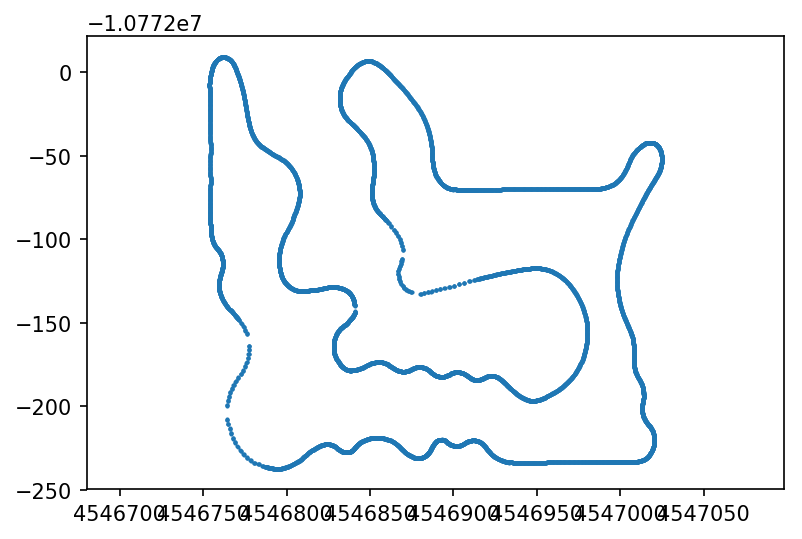

In [3]:
mask = (loc_ts > 300.0) &(loc_ts < 393.05)

plt.figure(dpi=150)
plt.axes().set_aspect('equal', 'datalim')
plt.scatter(loc_lat[mask], loc_lon[mask], s=1);

Make sure all the data is in float format, and create a set of
timesteps to sample at. OptimumLap needs a constant sampling frequency!
Sampling frequency can be adjusted with `samp_freq` (set to 25Hz here).

In [4]:
pts_x = loc_lat[mask].astype(np.float64)
pts_y = loc_lon[mask].astype(np.float64)
pts_t = loc_ts[mask].astype(np.float64)
samp_freq = 25.0
samples = np.arange(pts_t.min(), pts_t.max(), 1.0 / samp_freq)

Interpolate a spline from the given points. The smoothing factor should be set so that it follows the points but prevents large acceleration spikes.

In [5]:
smoothing = 2e2
tck1 = interpolate.splrep(pts_t, pts_x, s=smoothing, per=True)
tck2 = interpolate.splrep(pts_t, pts_y, s=smoothing, per=True)

Now evaluate the spline coordinates and first and second derivatives at the sample timesteps. The normal vectors are also calculated.

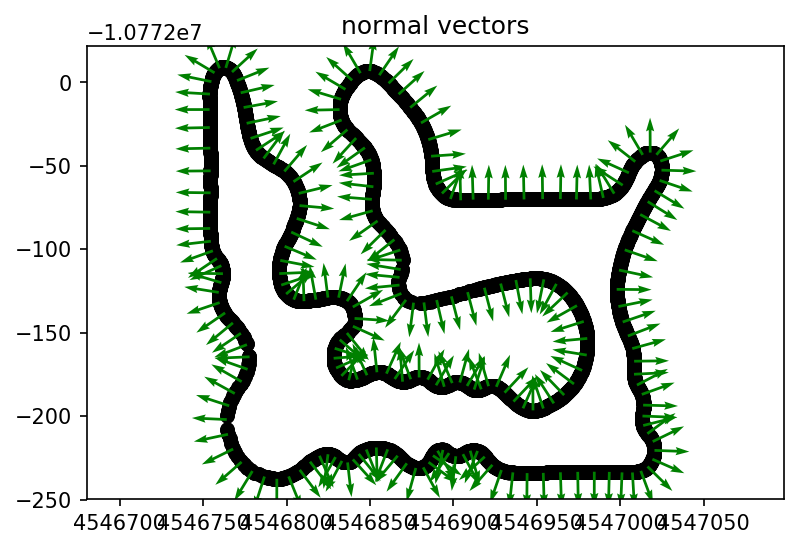

In [6]:
interp_t = samples
x_interp = interpolate.splev(interp_t, tck1) # x positions
y_interp = interpolate.splev(interp_t, tck2) # y positions

x_d1_interp = interpolate.splev(interp_t, tck1, der=1) # x velocity
y_d1_interp = interpolate.splev(interp_t, tck2, der=1) # y velocity
x_d2_interp = interpolate.splev(interp_t, tck1, der=2) # x accel
y_d2_interp = interpolate.splev(interp_t, tck2, der=2) # y accel

# magnitude of velocity aka speed
mag = np.sqrt(x_d1_interp**2 + y_d1_interp**2)

x_norm = y_d1_interp/mag   # x component of normal vector
y_norm = -x_d1_interp/mag  # y component of normal vector

# graph the stuff
plt.figure(dpi=150)
view = slice(None, None, 10) # show every 10th vector
plt.axes().set_aspect('equal', 'datalim')
plt.scatter(pts_x, pts_y, facecolors='black')
plt.quiver(x_interp[view], y_interp[view], x_norm[view], y_norm[view],
            scale=20, color='g')
plt.title('normal vectors');

OptimumLap wants a CSV of distance, speed, and lateral acceleration. Speed was computed above as the magnitude of velocity. Distance is computed by cumulatively integrating speed. Lateral acceleration is computed as the magnitude of the projection of acceleration onto the normal vector.

In [7]:
# dot product acceleration with normal vec
lateral_acc = x_norm*x_d2_interp + y_norm*y_d2_interp

In [8]:
# very slow
# there are better ways to cumulatively integrate but I'm lazy
dists = []
for i, t in enumerate(samples):
    f = lambda _t: np.sqrt(interpolate.splev(_t, tck1, der=1)**2 + interpolate.splev(_t, tck2, der=1)**2)
    d = integrate.quad(f, samples[0], t)
    dists.append(d)

/usr/local/lib/python3.5/dist-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


Write data to a CSV on disk:

In [9]:
outfile = 'lincoln_endurance_2018.csv'
with open(outfile, 'w') as f:
    f.write('Distance,Speed,Lateral Acceleration\n')
    f.write('m,m/s,m/s^2\n')
    f.write(',,\n')
    f.write(',,\n')
    for i, _ in enumerate(samples):
        f.write('{},{},{}\n'.format(dists[i][0], mag[i], lateral_acc[i]))

Then upload the generated CSV to http://share.optimumg.com/tracks/convert/ and download the OptimumLap track file. Done!